In [264]:
import numpy as np
import math
import sklearn
import graphviz
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [265]:
# Question 2.a
def load_data():
    fake = open('./data/clean_fake.txt', 'r')
    fake_stored = list(map(lambda s: s.strip(), fake))
    fake.close()

    real = open('./data/clean_real.txt', 'r')
    real_stored = list(map(lambda s: s.strip(), real))
    real.close()
    
    fake_target = [1 for i in range(len(fake_stored))]
    real_target = [0 for i in range(len(real_stored))]
    
    all_stored = fake_stored + real_stored
    all_target = fake_target + real_target
    
    # convert all headlines into array of vectors
    vectorizer = CountVectorizer()
    all_x = vectorizer.fit_transform(all_stored)
    
    # split into training, validation, and test sets
    x_train, x_rest, target_train, target_rest = train_test_split(all_x, all_target, train_size=0.7)
    x_validation, x_test, target_validation, target_test = train_test_split(x_rest, target_rest, train_size=0.5)
    
    return [x_train, target_train], [x_validation, target_validation], [x_test, target_test], vectorizer.get_feature_names()

In [270]:
# Question 2.b
def select_model(train, validation):
  
    classifiers = [tree.DecisionTreeClassifier(criterion='entropy', max_depth=None)]
    for i in range(2, 11, 2):
        classifiers.append(tree.DecisionTreeClassifier(criterion='entropy', max_depth=i))
        
    classifiers.append(tree.DecisionTreeClassifier(criterion='gini', max_depth=None))
    for i in range(2, 11, 2):
        classifiers.append(tree.DecisionTreeClassifier(criterion='gini', max_depth=i))
        
    fitted_classifiers = []
    for clf in classifiers:
        fitted_classifiers.append(clf.fit(train[0], train[1]))
      
    max_score = 0
    model = ""
    max_depth = None
    
    for clf in fitted_classifiers:
        new_score = clf.score(validation[0], validation[1])
        if new_score > max_score:
            max_score = new_score
            params = clf.get_params()
            model = params['criterion']
            max_depth = params['max_depth']
    
    return model, max_depth

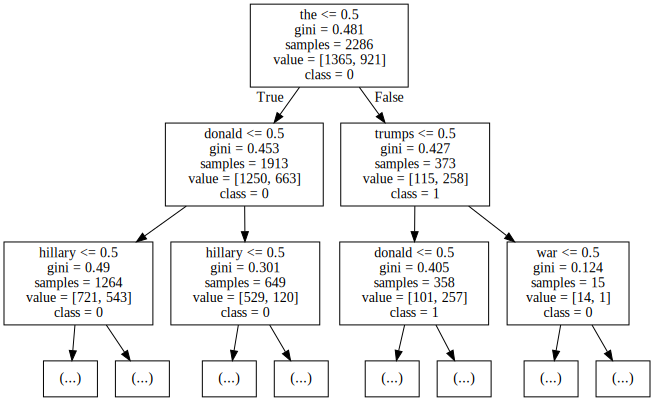

In [277]:
# Question 2.c
tr, v, te, fn = load_data()
model, max_depth = select_model(tr, v)
clf = tree.DecisionTreeClassifier(criterion=model, max_depth=max_depth)
clf = clf.fit(tr[0], tr[1])
clf_data = tree.export_graphviz(clf, max_depth=2, feature_names=fn, class_names=['0', '1'])

graph = graphviz.Source(clf_data)
graph

In [281]:
# Question 2.d
def compute_information_gain(keyword, data_train, features):
    k = features.index(keyword)
    contains_keyword = [[], []]
    missing_keyword = [[], []]
    
    for i in range(data_train[0].shape[0]):
        if data_train[0][i, k] == 1:
            contains_keyword[0].append(data_train[0][i].toarray())
            contains_keyword[1].append(data_train[1][i])
        else:
            missing_keyword[0].append(data_train[0][i].toarray())
            missing_keyword[1].append(data_train[1][i])
            
    n = data_train[0].shape[0]
    
    n_fake = data_train[1].count(1)
    n_real = n - n_fake
    
    n_contains = len(contains_keyword[0])
    n_missing = len(missing_keyword[0])
    
    n_fake_contains = contains_keyword[1].count(1)
    n_real_contains = n_contains - n_fake_contains
    
    n_fake_missing = missing_keyword[1].count(1)
    n_real_missing = n_missing - n_fake_missing
    
    h_y = -(n_fake/n)*math.log2(n_fake/n) - (n_real/n)*math.log2(n_real/n)
    h_y_contains = -(n_fake_contains/n_contains)*math.log2(n_fake_contains/n_contains) \
                    - (n_real_contains/n_contains)*math.log2(n_real_contains/n_contains)
    h_y_missing = -(n_fake_missing/n_missing)*math.log2(n_fake_missing/n_missing) \
                    - (n_real_missing/n_missing)*math.log2(n_real_missing/n_missing)
        
    info_gain = h_y - ((h_y_contains*n_contains/n) + (h_y_missing*n_missing/n))
    
    return info_gain  

In [291]:
# Question 2.d output
print("Information Gain with 'the': " + str(compute_information_gain("the", tr, fn)))
print("Information Gain with 'donald': " + str(compute_information_gain("donald", tr, fn)))
print("Information Gain with 'trumps': " + str(compute_information_gain("trumps", tr, fn)))
print("Information Gain with 'hillary': " + str(compute_information_gain("hillary", tr, fn)))
print("Information Gain with 'war': " + str(compute_information_gain("war", tr, fn)))

Information Gain with 'the': 0.032819239012047086
Information Gain with 'donald': 0.04818051297360848
Information Gain with 'trumps': 0.0412661903358289
Information Gain with 'hillary': 0.03259431220333198
Information Gain with 'war': 0.003457962708200202


In [283]:
# Question 3.3-b
def shuffle_data(data):
    data_shf = {}
    zipped = list(zip(data['X'], data['y']))
    np.random.shuffle(zipped)
    X, y = zip(*zipped)
    data_shf['X'] = np.asarray(X)
    data_shf['y'] = np.asarray(y)
    return data_shf

In [237]:
def split_data(data, num_folds, fold):
    length = len(data['X'])
    fold_size = length // num_folds
    data_rest = {'X': [], 'y': []}
    fold_num = 1
    data_fold = {}
    for i in range(0, length, fold_size):
        if fold_num == fold:
            data_fold['X'] = data['X'][i:i+fold_size] 
            data_fold['y'] = data['y'][i:i+fold_size]
        else:
            data_rest['X'] = data_rest['X'] + data['X'][i:i+fold_size].tolist()
            data_rest['y'] = data_rest['y'] + data['y'][i:i+fold_size].tolist()
        fold_num += 1
    data_fold['X'] = np.asarray(data_fold['X'])
    data_rest['X'] = np.asarray(data_rest['X'])
    return data_fold, data_rest

In [238]:
def train_model(data, lambd):
    n = data['X'].shape[1]
    step = np.add(data['X'].transpose()@data['X'], lambd*np.identity(n)) 
    model = np.linalg.inv(step) @ data['X'].transpose() @ data['y']
    return model

In [239]:
def predict(data, model):
    return data['X'] @ model

In [240]:
def loss(data, model):
    n = len(data['y'])
    return (np.linalg.norm(np.subtract(data['y'], predict(data, model)))**2)/n

In [248]:
def cross_validation(data, num_folds, lambd_seq):
    cv_error = []
    data_shf = shuffle_data(data)
    for i in range(0, len(lambd_seq)):
        lambd = lambd_seq[i]
        cv_loss_lmd = 0
        for fold in range(1, num_folds + 1):
            val_cv, train_cv = split_data(data, num_folds, fold)
            model = train_model(train_cv, lambd)
            cv_loss_lmd += loss(val_cv, model)
        cv_error.append(cv_loss_lmd / num_folds)
    
    return cv_error

In [249]:
# Question 3.3-a
data_train = {'X': np.genfromtxt('./data/data_train_X.csv', delimiter=','),
'y': np.genfromtxt('./data/data_train_y.csv', delimiter=',')}
data_test = {'X': np.genfromtxt('./data/data_test_X.csv', delimiter=','),
'y': np.genfromtxt('./data/data_test_y.csv', delimiter=',')}

In [253]:
# Question 3.3-c
lambd_seq = [i*(1.48/50) + 0.02 for i in range(0, 50)]

train_shf = shuffle_data(data_train)
test_shf = shuffle_data(data_test)

train_error = []
test_error = []

for lambd in lambd_seq:
    model = train_model(train_shf, lambd)
    train_error.append(loss(train_shf, model))
    test_error.append(loss(test_shf, model))

Text(0.5, 0.98, 'Loss and Error of Predictions')

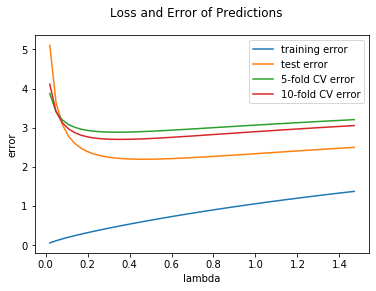

In [260]:
# Question 3.3-d
fold5_error = cross_validation(data_train, 5, lambd_seq)
fold10_error = cross_validation(data_train, 10, lambd_seq)

plt.plot(lambd_seq, train_error)
plt.plot(lambd_seq, test_error)
plt.plot(lambd_seq, fold5_error)
plt.plot(lambd_seq, fold10_error)

plt.legend(['training error', 'test error', '5-fold CV error', '10-fold CV error'])
plt.xlabel('lambda')
plt.ylabel('error')
plt.suptitle('Loss and Error of Predictions')